# Predicting Company Bankruptcy using Liability Financial Metrics

## Introduction

The occurrence of bankruptcies that are linked to business failures are becoming a common concern for many companies and their stakeholders. They can occur through the natural course of progression (such as smartphone cameras replacing the non-professional dedicated camera market), or be exacerbated through exogenous shocks (such as the dot-com bubble of 2001, or the 2007 financial crisis).  

In this analysis, we will determine if we can predict the looming bankruptcy of a company based on a variety of fundamental financial metrics. Specifically, we will be looking at various debt and liability metrics in conducting the analysis to determine if the tipping-point threshold of debt and liabilities which leads to company bankruptcy. 
We will use the Taiwanese Bankruptcy Prediction dataset from the Taiwan Economic Journal (TEJ), spanning from 1999-2009. Since its 1990 inception, the TEJ has focused on delivering essential financial market data [1]. Within this 1999-2000 period, the TEJ recorded 220 observations of bankruptcy within the total 6,819 observations they collected data on. Company bankruptcy was defined based on the business rules of the Taiwan Stock Exchange  [2].

The dataset includes 95 columns of financial metrics, and a 96th column f aor bankruptcy flag (yes/no).
We will use the bankruptcy flag as our classification variable.


[1] https://www.tejwin.com/en/about/

[2] 
Lyon,Robert. (2017). HTRU2. UCI Machine Learning Repository. https://doi.org/10.24432/C5DK6R.

## Preliminary Data Analysis

In [1]:
# We will start off by reading necessary libraries:
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)

options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Then we will read and tidy data.

# To read, we will need to:
# 1) Download the zip file from its source [2] above
# 2) Specify where to save the zip file
# 3) Unzip the file to our desired location
   
# In the process of tidying, we will need to:
# 1) Clean the headers of our data as numerous of them have spaces and/or invalid characters (such as "?" or "/")
# 2) Change our classification column, "bankruptcy", to a factor, and rename the 1 and 0 by their respective human definitions
# 3) Select the columns necessary to our analysis, namely: bankrupt, columns containing the word "debt", and columns containing any form of
# the word "liability"

#get file, which is stored as a .zip
url <- "https://archive.ics.uci.edu/static/public/572/taiwanese+bankruptcy+prediction.zip"
data_directory <- "data/"

dir.create(file.path(dirname(data_directory), "data")) #create the directory to save the file

zip_file_name <- "data.zip"
download.file(url, paste(data_directory, zip_file_name, sep=""), mode = "wb") #download file

#unzip the zipfile
unzip(paste(data_directory, zip_file_name, sep=""),exdir=data_directory) #unzip the data

taiwan_data <- read_csv("data/data.csv") |>
               clean_names(replace = c('/' = " to ", '%' = "percent")) #the headers have numerous spaces and/or invalid characters.  But we we want to preserve % as percent, and / as to.

taiwan_tidy <- taiwan_data |>
                mutate(bankrupt = fct_recode(factor(bankrupt), "Bankrupt" = '1', "Not Bankrupt" = '0'), debt_ratio_percent = debt_ratio_percent * 100) |> #change numerical values to factors/classifications.
                select(bankrupt, contains("debt"), contains("liabilit")) |>  #select 1) classification column (bankrupt), 2) columns containing "Debt", and 3) columns containing any form of liability
                select(!c(interest_bearing_debt_interest_rate, liability_assets_flag)) #remove two additional columns - interest rate, and liability asset flag.

taiwan_tidy

Warning message in dir.create(file.path(dirname(data_directory), "data")):
“'./data' already exists”
Rows: 6819 Columns: 96
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (96): Bankrupt?, ROA(C) before interest and depreciation before interest...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


bankrupt,total_debt_to_total_net_worth,debt_ratio_percent,contingent_liabilities_to_net_worth,quick_assets_to_current_liability,cash_to_current_liability,current_liability_to_assets,operating_funds_to_liability,inventory_to_current_liability,current_liabilities_to_liability,current_liabilities_to_equity,long_term_liability_to_current_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long_term_liability,cash_flow_to_liability,current_liability_to_current_assets,liability_to_equity,equity_to_liability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bankrupt,0.02126592,20.75763,0.006478502,0.001996771,1.47336e-04,0.14730845,0.3340152,0.001035990,0.6762692,0.3390770,0.025592368,0.6762692,0.3390770,0.1265495,0.4586091,0.11825048,0.2902019,0.01646874
Bankrupt,0.01250239,17.11763,0.005835039,0.004136030,1.38391e-03,0.05696283,0.3411060,0.005209682,0.3085886,0.3297401,0.023946819,0.3085886,0.3297401,0.1209161,0.4590011,0.04777528,0.2838460,0.02079431
Bankrupt,0.02124769,20.75158,0.006561982,0.006302481,5.34000e+09,0.09816206,0.3367315,0.013878786,0.4460275,0.3347769,0.003715116,0.4460275,0.3347769,0.1179223,0.4592540,0.02534649,0.2901885,0.01647411
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Not Bankrupt,0.0013915866,3.893944,0.005365848,0.035531293,0.088212480,0.02441366,0.3588474,0.007809807,0.5539642,0.3269206,0.0e+00,0.5539642,0.3269206,0.1109332,0.4524647,0.007542458,0.2757887,0.09764874
Not Bankrupt,0.0038163762,8.697887,0.007067734,0.007753306,0.007133218,0.08319943,0.3802508,0.013333639,0.8932409,0.3292936,3.2e+09,0.8932409,0.3292936,0.1109574,0.4713133,0.022916427,0.2775472,0.04400945
Not Bankrupt,0.0004614304,1.414880,0.006368212,0.051480515,0.066673545,0.01851735,0.2395847,0.000000000,1.0000000,0.3266903,0.0e+00,1.0000000,0.3266903,0.1109332,0.4832848,0.005579107,0.2751141,0.23390224


In [3]:
# Following a bit of data tidying, we will separate our data into respective training and testing groups.
# As there are only 220 instances of bankruptcy in the dataset of 6,819 observations (and it is also the column we are trying to predict),
# we will select bankrupt as our strata.

taiwan_split <- initial_split(taiwan_tidy, prop = 0.75, strata = bankrupt)
taiwan_training <- training(taiwan_split)
taiwan_testing <- testing(taiwan_split)

In [4]:
# Below we present an initial data summary using training data, noting the count of Bankrupt vs Not Bankrupt against a widely-recognized
# financial metric, the debt ratio, presented as an average for each of Bankrupt and Not Bankrupt.
# Debt ratio is defined as (total debt / total assets):

taiwan_training_count_and_debt_summary <- taiwan_training |>
                                          group_by(bankrupt) |>
                                          summarize(Observations = n(), Average_Debt_Ratio_Percent = mean(debt_ratio_percent))

taiwan_training_count_and_debt_summary

bankrupt,Observations,Average_Debt_Ratio_Percent
<fct>,<int>,<dbl>
Not Bankrupt,4933,11.07891
Bankrupt,181,18.58470


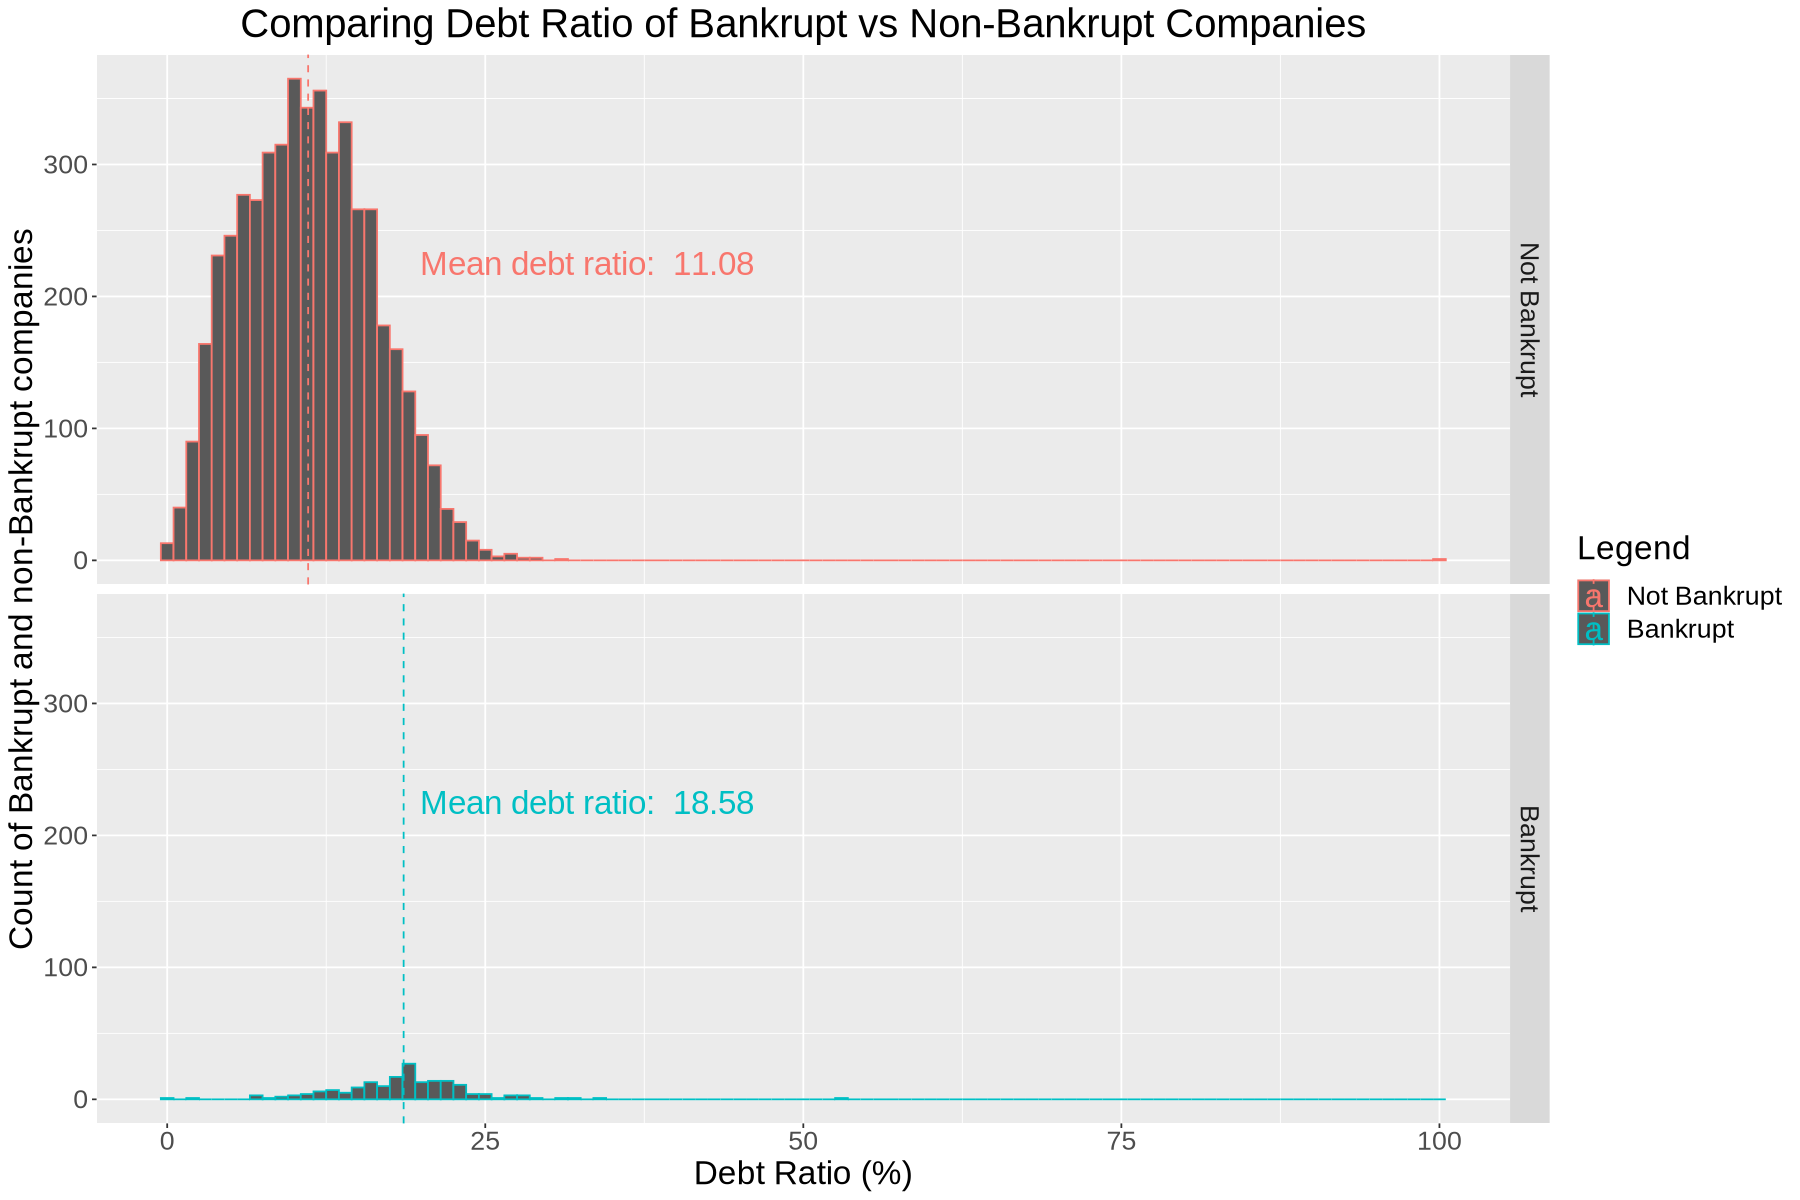

In [5]:
# In the following graph, we visualize this average debt ratio %:

options(repr.plot.width = 15, repr.plot.height = 10)

taiwan_training_histogram <- taiwan_training |>
                             ggplot(aes (x = debt_ratio_percent, colour = bankrupt)) +
                             geom_histogram(binwidth = 1, position = "identity") +
                             facet_grid(bankrupt ~.) +
                             geom_vline(data = taiwan_training_count_and_debt_summary, aes (xintercept=Average_Debt_Ratio_Percent, color=bankrupt), linetype="dashed") +
                             labs(x = "Debt Ratio (%)", y = "Count of Bankrupt and non-Bankrupt companies", colour = "Legend") +
                             ggtitle("Comparing Debt Ratio of Bankrupt vs Non-Bankrupt Companies") +
                             geom_text(data = taiwan_training_count_and_debt_summary, aes(label = paste("Mean debt ratio: ", round(Average_Debt_Ratio_Percent,2)), x = 33, y = 225), size = 7) +
                             theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5)) 
taiwan_training_histogram

## Methods

In conducting our analysis, we are focusing on financial metrics which include debt and/or liabilities, and have narrowed down the data from 96 to 19 columns. Within that 19, we will conduct analysis to determine which metrics have the greatest impact on predicting bankruptcy. Furthermore, we anticipate more refinement of the column numbers as the analysis progresses, to exclude more financial metrics not relevant to the analysis.

As depicted in the preliminary histogram above, our data forms an approximate normal distribution. There appears to be a noticeable difference between the debt ratio of the two groups, as the Bankrupt companies had a higher average debt ratio compared to the Non-Bankrupt companies. As a result, we can visualize our data by comparing the averages of certain metrics for Bankrupt companies vs Non-Bankrupt companies. 

## Expected Outcomes and Significance

We expect to find that companies which have higher levels of liabilities and higher levels of debt, relative to their assets are more likely to face bankruptcy.

The impacts of these findings could help create future legislation for the maximum allowable debt and liabilities for a given level of assets. For instance, from 1999 to 2009 two major financial crises were outlined earlier. If the firms had a better grasp of their obligations, would they have been able to weather the financial crisis storms?

Based on the findings, some questions arise: what should be the maximum allowable limits? How could these limits be policed or monitored? Are some industries more susceptible to higher debt and liability levels relative to others (is it appropriate for a tech firm to have the same levels as a grocery store?), and so forth.